In [1]:
# PREPARE DATA
from pathlib import Path
from fibrosisanalysis.parsers.stats_loader import StatsLoader
from fibrosisanalysis.slice.heart_slice import HeartSliceBuilder
from fibrosisanalysis.analysis import (
    ObjectsPropertiesBuilder,
    SegmentsPropertiesBuilder
)

# path = Path(__file__).parent.parent.parent.joinpath('data')
path = Path('/Users/arstanbek/Library/CloudStorage/OneDrive-UGent/data')
path_stats = path

heart = 'E11444_LMNA'
slice_name = 'E11444_08_SC2'

# heart = 'E11444_LMNA'
# slice_name = 'E11444_10_SC2'

n_radial = 3
n_angular = 12
node_step = 10

heart_slice_builder = HeartSliceBuilder()
heart_slice_builder.build_from_file(path, heart, slice_name,
                                    n_angular, n_radial,
                                    node_step)
heart_slice = heart_slice_builder.heart_slice

# Load stats
path_slice_stats = path_stats.joinpath(heart, 'Stats', slice_name)
stats_loader = StatsLoader(path_stats)
object_stats = stats_loader.load_slice_data(path_slice_stats)

# Build objects properties
objects_props_builder = ObjectsPropertiesBuilder()
objects_props_builder.build_from_stats(object_stats)
objects_props_builder.add_slice_props(heart_slice)
objects_props = objects_props_builder.objects_props

# Build segment properties
segments_props_builder = SegmentsPropertiesBuilder()
segments_props_builder.build(heart_slice, objects_props)
segments_props = segments_props_builder.props

In [2]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors, lines

from bitis.texture.properties import PolarPlots


def draw_text(ax, rx, ry, text, fontsize=10):
    ax.text(rx, ry, str(text), color='black', fontsize=fontsize,
            bbox=dict(facecolor='white', edgecolor='white',
                      boxstyle='round, pad=0.1'),
            ha='center', va='center')


def draw_ellipse(ax, rx, ry, dist_ellipse, n_std=2, scale=10):
    r = n_std * scale * dist_ellipse.full_radius
    theta = dist_ellipse.full_theta
    y_ellipse, x_ellipse = PolarPlots.polar_to_cartesian(r, theta)
    ax.plot(rx + x_ellipse, ry + y_ellipse, color='red')


def draw_points(ax, rx, ry, r, theta, n_std=2, scale=10, size=1):
    r, theta, density = PolarPlots.sort_by_density(r, theta)
    y, x = PolarPlots.polar_to_cartesian(r, theta)
    x = n_std * scale * x + rx
    y = n_std * scale * y + ry
    ax.scatter(x, y, c=density, s=size)


def draw_lines(fig, ax0, ax1, x0, y0, x1, y1, lw=0.5):
    fig.canvas.draw()
    transFigure = fig.transFigure.inverted()

    x0, y0 = transFigure.transform(ax0.transData.transform([x0, y0]))
    x1, y1 = transFigure.transform(ax1.transData.transform([x1, y1]))

    line = lines.Line2D((x0, x1), (y0, y1),
                        transform=fig.transFigure, lw=lw, color='black')

    fig.lines.append(line)


def draw_segment_zoom(ax, axinset, spline_edges, segment_indexes, fig):
    k = segment_indexes[0] - 1
    x = [spline_edges[0].ordered_nodes[k, 1],
         spline_edges[-1].ordered_nodes[k, 1],
         spline_edges[0].ordered_nodes[k+1, 1],
         spline_edges[-1].ordered_nodes[k+1, 1]]

    y = [spline_edges[0].ordered_nodes[k, 0],
         spline_edges[-1].ordered_nodes[k, 0],
         spline_edges[0].ordered_nodes[k+1, 0],
         spline_edges[-1].ordered_nodes[k+1, 0]]
    
    for i in [0, 2, 3]:
        draw_lines(fig, ax, axinset, x[i], y[i], x[i], y[i], lw=1.)

    x1 = x[-2] + 0.27 * (x[-1] - x[-2])
    y1 = y[-2] + 0.27 * (y[-1] - y[-2])
    draw_lines(fig, ax, axinset, x[1], y[1], x1, y1, lw=1.)

In [7]:
def draw_circ_edges(ax, spline_edges, start=0, end=None, lw=0.5):
    
    for spline_edge in spline_edges:
        x = spline_edge.nodes[start: end, 1]
        y = spline_edge.nodes[start: end, 0]

        if end is None:
            x = np.concatenate([x, [x[0]]])
            y = np.concatenate([y, [y[0]]])

        ax.plot(x, y, 'k', lw=lw)
        

def draw_radial_edges(ax, spline_edges, radial_indexes=None, lw=0.5):

    if radial_indexes is None:
        radial_nodes = spline_edges[0].ordered_nodes[:, 0]
        radial_indexes = np.arange(len(radial_nodes))

    for k in radial_indexes:
        x = [spline_edges[0].ordered_nodes[k, 1],
             spline_edges[-1].ordered_nodes[k, 1]]
        y = [spline_edges[0].ordered_nodes[k, 0],
             spline_edges[-1].ordered_nodes[k, 0]]
        ax.plot(x, y, 'k', lw=lw)


def draw_segments(ax, spline_edges, segment_indexes=None, lw=0.5):

    if segment_indexes is None:
        draw_circ_edges(ax, spline_edges, lw=lw)
        draw_radial_edges(ax, spline_edges, lw=lw)
        return
    
    for segment_index in segment_indexes:
        radial_indexes = [segment_index - 1, segment_index]

        start = (segment_index - 1) * node_step
        end = segment_index * node_step + 1
        draw_circ_edges(ax, spline_edges, start=start, end=end, lw=lw)
        draw_radial_edges(ax, spline_edges, radial_indexes, lw=lw)

In [8]:
from skimage import segmentation, morphology
from bitis.texture.properties import DistributionEllipseBuilder
from bitis.texture.analysis import ObjectAnalysis


def clear_image(image, min_size=10):
    mask = image == 2
    mask = morphology.remove_small_objects(mask, min_size)
    mask = segmentation.clear_border(mask)
    image[(mask == 0) & (image > 0)] = 1
    return image


def draw_segment(ax, image, x0, x1, y0, y1):
    image_seg = image.copy()
    im = image.copy()
    im = im[x0:x1, y0:y1]
    im = clear_image(im)

    image_seg[image_seg > 0] = 1
    image_seg[x0:x1, y0:y1] = im

    seg_objects_props = ObjectAnalysis().build_props(image_seg == 2)


    ax.imshow(image_seg, cmap=cmap, origin='lower', vmin=0, vmax=2)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('equal')
    ax.set_xlim([y0, y1])
    ax.set_ylim([x0, x1])

    return seg_objects_props


def draw_segment_labels(ax, segment_labels, segment_indexes=None,
                        fontsize=7):
    
    if segment_indexes is None:
        segment_indexes = np.arange(1, segment_labels.max() + 1)

    for index in segment_indexes:
        coords = np.argwhere(segment_labels == index)
        ry, rx = coords.mean(axis=0)
        draw_text(ax, rx, ry, index, fontsize=fontsize)


def draw_sa(ax, segment_labels, objects_props, segment_indexes=None, n_std=2,
            scale=10, point_size=1):

    if segment_indexes is None:
        segment_indexes = np.arange(1, segment_labels.max() + 1)

    for index in segment_indexes:
        props = objects_props[objects_props['segment_labels'] == index]

        r = props['axis_ratio'].values
        theta = props['orientation'].values

        r = np.concatenate([r, r])
        theta = np.concatenate([theta, theta + np.pi])

        dist_ellipse_builder = DistributionEllipseBuilder()
        dist_ellipse_builder.build(r, theta, n_std=n_std)
        dist_ellipse = dist_ellipse_builder.dist_ellipse

        coords = np.argwhere(segment_labels == index)
        ry, rx = coords.mean(axis=0)

        draw_points(ax, rx, ry, r, theta, scale=scale, size=point_size)
        draw_ellipse(ax, rx, ry, dist_ellipse, scale=scale)


def swap_axis(angle):
    """
    Swap axis for polar plot.
    """
    return 0.5 * np.pi - angle


def draw_sa_polar(ax, objects_props, n_std=2):

    r = objects_props['axis_ratio'].values
    theta = swap_axis(objects_props['orientation'].values)
    r = np.concatenate([r, r])
    theta = np.concatenate([theta, theta + np.pi])

    r, theta, d = PolarPlots.sort_by_density(r, theta)
    ax.scatter(theta, r, c=d, s=30, alpha=1, cmap='viridis')

    dist_ellipse_builder = DistributionEllipseBuilder()
    dist_ellipse = dist_ellipse_builder.build(r, theta, n_std=n_std)
    orientation = dist_ellipse.orientation % np.pi
    orientation += np.pi
    ax.plot(dist_ellipse.full_theta, dist_ellipse.full_radius, color='red')
    ax.quiver(0, 0, orientation, 0.5 * dist_ellipse.width,
              angles='xy', scale_units='xy', scale=1, color='red')
    ax.quiver(0, 0, 0.5 * np.pi + orientation,
              0.5 * dist_ellipse.height,
              angles='xy', scale_units='xy', scale=1, color='red')
    

def draw_equivalent_ellipses(ax, objects_props):
    r = objects_props['axis_ratio'].values
    theta = swap_axis(objects_props['orientation'].values)
    r_d = np.concatenate([r, r])
    theta_d = np.concatenate([theta, theta + np.pi])

    _, _, dens_d = PolarPlots.point_density(r_d, theta_d)
    inds = np.argsort(dens_d)
    inds = inds[inds < len(r)]
    dens = dens_d[inds]

    colors = plt.get_cmap('viridis')

    for i, d in zip(inds, dens):
        color = colors(d / dens.max())
        width = objects_props['major_axis_length'].iloc[i]
        height = objects_props['minor_axis_length'].iloc[i]
        alpha = objects_props['orientation'].iloc[i]
        centroids = objects_props[['centroid-0', 'centroid-1']].values
        xy = centroids[i]

        res = PolarPlots.rotated_ellipse(width, height, 0.5 * np.pi - alpha)
        y, x = PolarPlots.polar_to_cartesian(*res)
        y += xy[1]
        x += xy[0]
        ax.plot(y, x, color=color, lw=1)


def draw_orientation(ax, segments_props, segment_indexes, n_std=2, scale=10):
    x = segments_props['centroid-0'].values[segment_indexes - 1]
    y = segments_props['centroid-1'].values[segment_indexes - 1]

    edge_direction = segments_props['edge_direction'].values[segment_indexes - 1]
    ellipse_width = segments_props['sa_major_axis'].values[segment_indexes - 1]
    r_orientation = segments_props['relative_orientation'].values[segment_indexes - 1]

    e_orientation = edge_direction - r_orientation

    U = n_std * scale * 0.5 * ellipse_width * np.cos(edge_direction)
    V = n_std * scale * 0.5 * ellipse_width * np.sin(edge_direction)
    ax.quiver(y, x, V, U, scale_units='xy', scale=1, color='black')

    U = n_std * scale * 0.5 * ellipse_width * np.cos(e_orientation)
    V = n_std * scale * 0.5 * ellipse_width * np.sin(e_orientation)
    ax.quiver(y, x, V, U, scale_units='xy', scale=1, color='red')

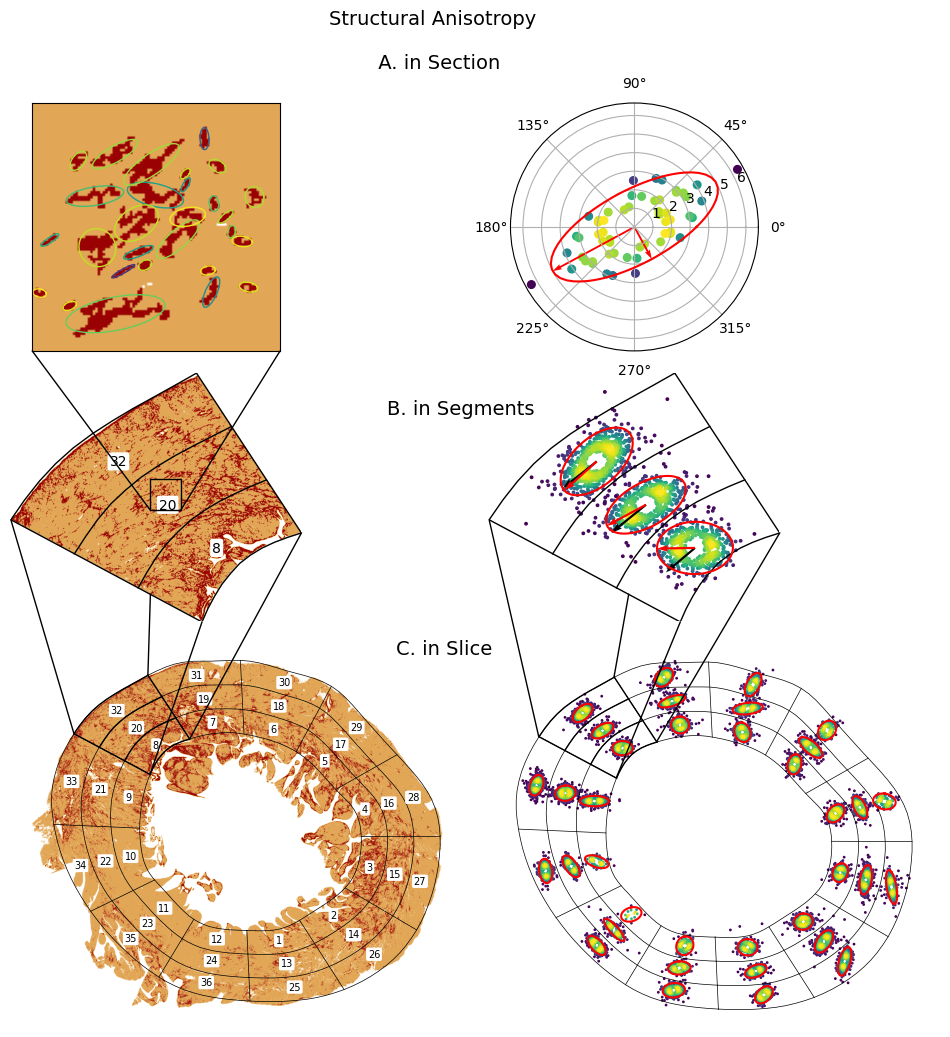

In [9]:
from matplotlib import colors


cmap = colors.LinearSegmentedColormap.from_list(
    'fibrosis', [(0, 'white'),
                 (0.5, '#e2a858'),
                 (1, '#990102')])

segment_indexes = np.array([8, 20, 32])

fig = plt.figure(figsize=(12, 12))

# mosaic = [['seg', 'sa_seg'],
#           ['s_zoom', 'sa_zoom'],
#           ['segments', 'sa']]

mosaic = [['seg', 'seg', 'empty0', 'sa_seg', 'sa_seg', 'empty1'],
          ['seg', 'seg', 'empty0', 'sa_seg', 'sa_seg', 'empty1'],

          ['s_zoom', 's_zoom', 'empty2', 'sa_zoom', 'sa_zoom', 'empty3'],
          ['s_zoom', 's_zoom', 'empty2', 'sa_zoom', 'sa_zoom', 'empty3'],

          ['segments', 'segments', 'segments', 'sa', 'sa', 'sa'],
          ['segments', 'segments', 'segments', 'sa', 'sa', 'sa'],
          ['segments', 'segments', 'segments', 'sa', 'sa', 'sa']]

axs = fig.subplot_mosaic(mosaic,
                         per_subplot_kw={'sa_seg': dict(projection='polar')})
# plt.subplots_adjust(wspace=0.01, hspace=0.1)

for m in mosaic:
    for subplot in m:
        if subplot.startswith('empty'):
            ax = axs[subplot]
            ax.axis('off')

ax = axs['segments']
ax.set_aspect('equal')
ax.imshow(heart_slice.image, cmap=cmap, origin='lower')

segment_mask = np.isin(heart_slice.total_segments, segment_indexes)
# Show image
im = heart_slice.image.copy()
im[~segment_mask] = 0
axs['s_zoom'].imshow(im, cmap=cmap, origin='lower')

coords = np.argwhere(segment_mask)
x_min = np.min(coords[:, 0])
x_max = np.max(coords[:, 0])
y_min = np.min(coords[:, 1])
y_max = np.max(coords[:, 1])

d_x = x_max - x_min
x0 = int(x_min + 0.45 * d_x)
x1 = x0 + 100

d_y = y_max - y_min
y0 = int(y_min + 0.48 * d_y)
y1 = y0 + 100

# Show segment
seg_objects_props = draw_segment(axs['seg'], heart_slice.image, x0, x1, y0, y1)

for subplot in ['segments', 'sa']:
    ax = axs[subplot]
    ax.set_aspect('equal')
    ax.axis('off')
    draw_segments(ax, heart_slice.spline_edges)
    draw_segments(ax, heart_slice.spline_edges,
                  segment_indexes=segment_indexes[:1], lw=1.)

for subplot in ['s_zoom', 'sa_zoom']:
    ax = axs[subplot]
    ax.set_aspect('equal')
    # ax.axis('off')
    draw_segments(ax, heart_slice.spline_edges,
                  segment_indexes=segment_indexes[:1], lw=1.)

for subplot in ['s_zoom', 'sa_zoom']:
    ax = axs[subplot]
    ax.set_xlim([y_min, y_max])
    ax.set_ylim([x_min, x_max])
    ax.set_aspect('equal')
    ax.axis('off')

axs['s_zoom'].indicate_inset_zoom(axs['seg'],
                                  edgecolor="black",
                                  lw=1,
                                  alpha=1)

draw_segment_zoom(axs['segments'],
                  axs['s_zoom'], heart_slice.spline_edges,
                  segment_indexes, fig)
draw_segment_zoom(axs['sa'],
                  axs['sa_zoom'], heart_slice.spline_edges,
                  segment_indexes, fig)

draw_segment_labels(axs['segments'], heart_slice.total_segments)
draw_segment_labels(axs['s_zoom'], heart_slice.total_segments,
                    segment_indexes=segment_indexes, fontsize=10)

draw_sa(axs['sa'], heart_slice.total_segments, objects_props)
draw_sa(axs['sa_zoom'], heart_slice.total_segments, objects_props,
        segment_indexes=segment_indexes, scale=15, point_size=3)

draw_sa_polar(axs['sa_seg'], seg_objects_props)
draw_equivalent_ellipses(axs['seg'], seg_objects_props)

draw_orientation(axs['sa_zoom'], segments_props, segment_indexes, scale=15)

# axs['seg'].set_title('A. Section', loc='left', x=-0.4, y=1., fontsize=12)
# axs['sa_seg'].set_title('B. SA in Section', loc='left', x=-0.45, y=1., fontsize=12)

# axs['s_zoom'].set_title('C. Segments', loc='left', x=-0.28, y=0.8, fontsize=12)
# axs['sa_zoom'].set_title('D. SA in Segments', loc='left', x=-0.32, y=0.8, fontsize=12)

# axs['segments'].set_title('E. Slice', loc='left', x=-0.2, y=0.8, fontsize=12)
# axs['sa'].set_title('F. SA in Slice', loc='left', x=-0.25, y=0.8, fontsize=12)

axs['sa_seg'].set_title('Structural Anisotropy \n \n A. in Section',
                        loc='center',
                        x=-0.3,
                        fontsize=14)
axs['sa_zoom'].set_title('B. in Segments', loc='center',
                         x=-0.1, y=0.8,
                         fontsize=14)
axs['sa'].set_title('C. in Slice', loc='center', x=-0.12,
                    y=0.95, fontsize=14)


# axs['segments'].set_title('E. Segmented Slice', loc='left', y=-0.1, fontsize=12)
# axs['sa'].set_title('F. Structural Anisotropy of the Slice', loc='left',
#                     y=-0.1, fontsize=12)

plt.show()

In [10]:
path_save = Path('/Users/arstanbek/Projects/FibrosisAnalysis/paperfigures/figures')
fig.savefig(path_save.joinpath('slice_anisotropy.png'),
            dpi=300, bbox_inches='tight')